In [141]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import seaborn as sns
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf

import warnings
from time import time
import math

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow.keras import metrics

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import sklearn.metrics as sm

In [142]:
dataBlocks = []
for num in range(1,112):
    df = pd.read_csv("dane/daily_dataset/daily_dataset/block_"+str(num)+".csv")
    dataBlocks.append(df)
data = pd.concat(dataBlocks, ignore_index=True)

In [143]:
data['date_time'] = pd.to_datetime(data['day'])
data['energy_sum'] = pd.to_numeric(data['energy_sum'], errors='coerce')
data = data.dropna(subset=['energy_sum'])

In [144]:
data['year'] = data['date_time'].apply(lambda x: x.year)
data['quarter'] = data['date_time'].apply(lambda x: x.quarter)
data['month'] = data['date_time'].apply(lambda x: x.month)
data['day'] = data['date_time'].apply(lambda x: x.day)

In [145]:
data = data.loc[:,['date_time','energy_sum', 'year','quarter','month','day']]
data.sort_values('date_time', inplace=True, ascending=True)
data = data.reset_index(drop=True)
data['weekday'] = data['date_time'].apply(lambda x: x.weekday() < 5).astype(int)

In [146]:
data.head()

,date_time,energy_sum,year,quarter,month,day,weekday
0,2011-11-23,1.283,2011,4,11,23,1
1,2011-11-23,7.408,2011,4,11,23,1
2,2011-11-23,3.036,2011,4,11,23,1
3,2011-11-23,5.619,2011,4,11,23,1
4,2011-11-23,5.798,2011,4,11,23,1


In [147]:
data.tail()

,date_time,energy_sum,year,quarter,month,day,weekday
3484824,2014-02-28,0.225,2014,1,2,28,1
3484825,2014-02-28,0.096,2014,1,2,28,1
3484826,2014-02-28,0.050,2014,1,2,28,1
3484827,2014-02-28,0.144,2014,1,2,28,1
3484828,2014-02-28,0.000,2014,1,2,28,1


In [148]:
print('Liczba wierszy i kolumn:', data.shape)
print('Najstarsza data:', data.date_time.min())
print('Najnowsza data:', data.date_time.max())

Liczba wierszy i kolumn: (3484829, 7)
Najstarsza data: 2011-11-23 00:00:00
Najnowsza data: 2014-02-28 00:00:00


In [149]:
energyPerDay = data.groupby('date_time')[['energy_sum']].sum()
data.drop_duplicates(subset=['date_time'], keep='first', inplace=True)
energyPerDay.reset_index()
data = data.merge(energyPerDay, on='date_time', how='left')
data.drop(['energy_sum_x'], inplace=True, axis=1)
data.rename(columns={'energy_sum_y':'energy_sum'}, inplace=True)

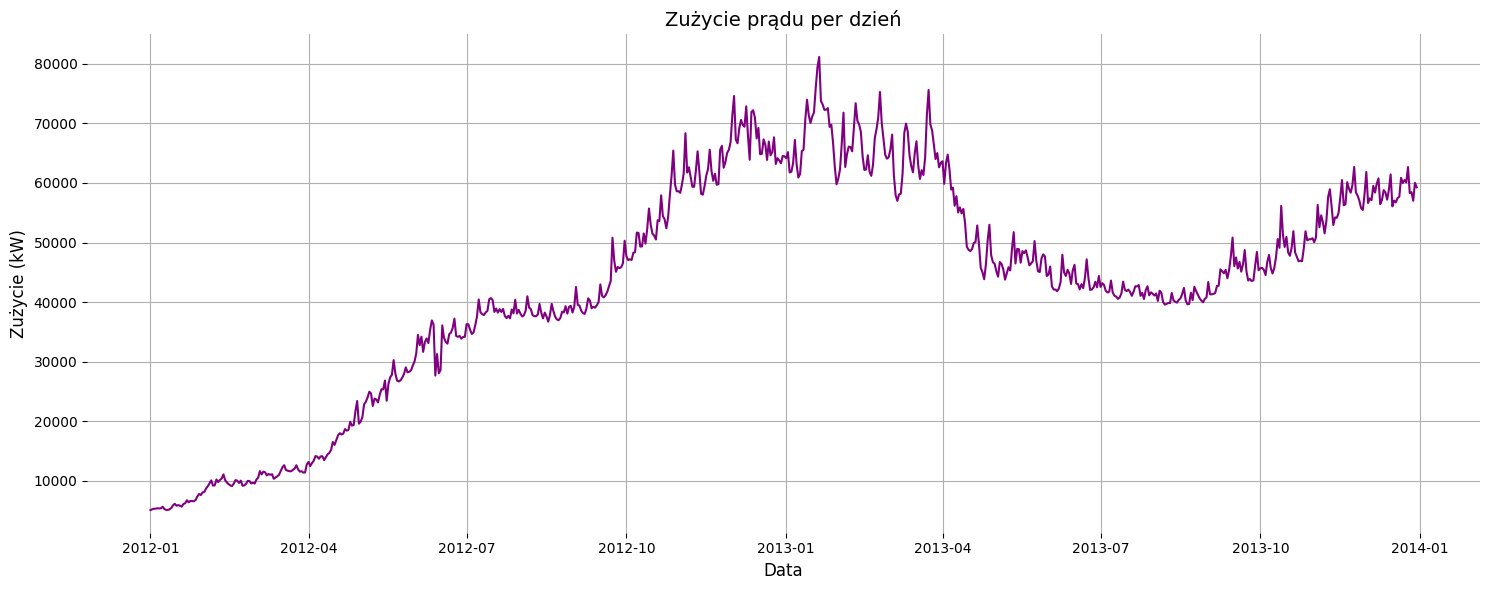

In [150]:
data1 = data[(data.date_time >= '2012-01-01') & (data.date_time < '2013-12-31')]

plt.figure(figsize=(15,6))
plt.plot(data1.date_time, data1.energy_sum, color='purple')
plt.ylabel('Zużycie (kW)', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.title('Zużycie prądu per dzień', fontsize=14)
plt.tight_layout()
plt.grid(True)
sns.despine(bottom=True, left=True)
plt.show()

In [151]:
dataset = data.energy_sum.values.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [152]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [153]:
X_train, Y_train = create_dataset(train, 30)
X_test, Y_test = create_dataset(test, 30)
print(X_train.shape)
print(X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape)
print(X_test.shape)

(549, 30)
(218, 30)
(549, 1, 30)
(218, 1, 30)


In [154]:
model = Sequential()
model.add(GRU(units=1000, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=500, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=500, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid', kernel_constraint=MaxNorm(3)))

#sgd = SGD(learning_rate=0.2, momentum=0.9)
#model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer='rmsprop')
#model.compile(loss=tf.keras.losses.MeanSquaredError(reduction="none"), optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])


history = model.fit(X_train, Y_train, epochs=100, batch_size=50, validation_data=(X_test, Y_test), verbose=2, shuffle=False)

c:\Users\3764\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
11/11 - 6s - 587ms/step - loss: 0.0631 - val_loss: 0.0084
Epoch 2/100
11/11 - 1s - 78ms/step - loss: 0.0518 - val_loss: 0.0044
Epoch 3/100
11/11 - 1s - 78ms/step - loss: 0.0437 - val_loss: 0.0039
Epoch 4/100
11/11 - 1s - 78ms/step - loss: 0.0338 - val_loss: 0.0040
Epoch 5/100
11/11 - 1s - 77ms/step - loss: 0.0227 - val_loss: 0.0046
Epoch 6/100
11/11 - 1s - 77ms/step - loss: 0.0135 - val_loss: 0.0041
Epoch 7/100
11/11 - 1s - 78ms/step - loss: 0.0080 - val_loss: 0.0021
Epoch 8/100
11/11 - 1s - 76ms/step - loss: 0.0061 - val_loss: 0.0015
Epoch 9/100
11/11 - 1s - 77ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 10/100
11/11 - 1s - 77ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 11/100
11/11 - 1s - 77ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 12/100
11/11 - 1s - 79ms/step - loss: 0.0050 - val_loss: 0.0020
Epoch 13/100
11/11 - 1s - 76ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 14/100
11/11 - 1s - 77ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 15/100
11/11 - 1s - 78

In [155]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 1000)        │     3,096,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 1, 1000)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 1, 500)         │     2,253,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1, 500)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 1, 500)         │     1,503,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 1, 500)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 100)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,065,404 (53.66 MB)

 Trainable params: 7,032,701 (26.83 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,032,703 (26.83 MB)

In [156]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Średni błąd bezwzględny na zbiorze testowym:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Pierwiastek z błędu średniokwadratowego na zbiorze testowym: ',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Średni błąd bezwzględny na zbiorze treningowym:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Pierwiastek z błędu średniokwadratowego na zbiorze testowym:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Średni błąd bezwzględny na zbiorze testowym: 2562.7907203107575
Pierwiastek z błędu średniokwadratowego na zbiorze testowym:  3477.9760600358513
Średni błąd bezwzględny na zbiorze treningowym: 2264.299411042912
Pierwiastek z błędu średniokwadratowego na zbiorze testowym: 2690.0404277541365


In [157]:
print("R2 score =", round(sm.r2_score(Y_test[0], test_predict[:,0]), 2))

R2 score = 0.85


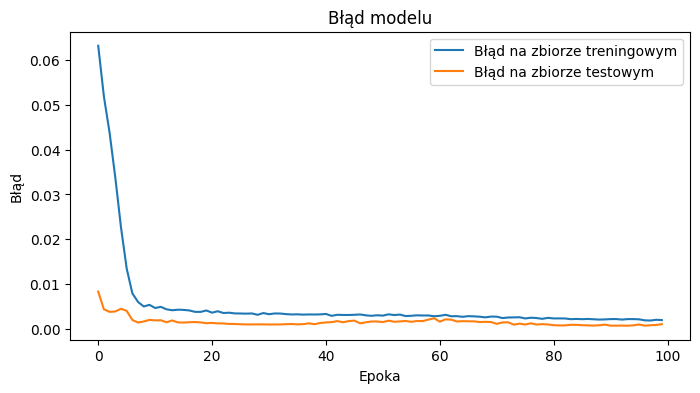

In [158]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Błąd na zbiorze treningowym')
plt.plot(history.history['val_loss'], label='Błąd na zbiorze testowym')
plt.title('Błąd modelu')
plt.ylabel('Błąd')
plt.xlabel('Epoka')
plt.legend(loc='upper right')
plt.show()

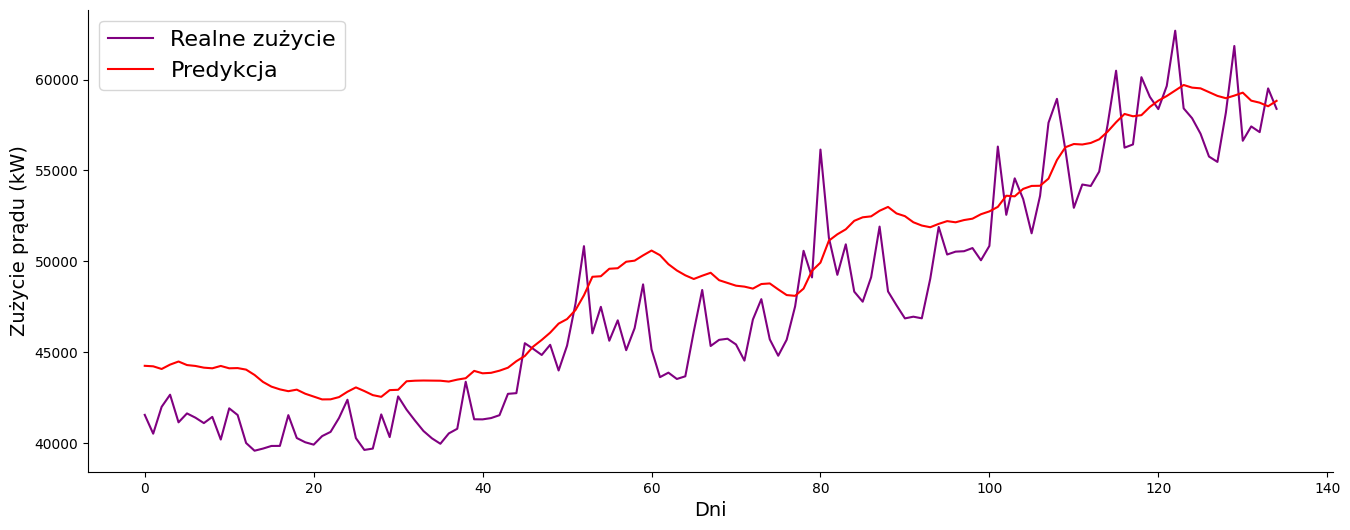

In [159]:
aa=[x for x in range(135)]
                    
plt.figure(figsize=(15,6))
plt.plot(aa, Y_test[0][:135], label="Realne zużycie", color='purple')
plt.plot(aa, test_predict[:,0][:135], label="Predykcja", color='red')
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Zużycie prądu (kW)', size=14)
plt.xlabel('Dni', size=14)
plt.legend(fontsize=16)
plt.show()

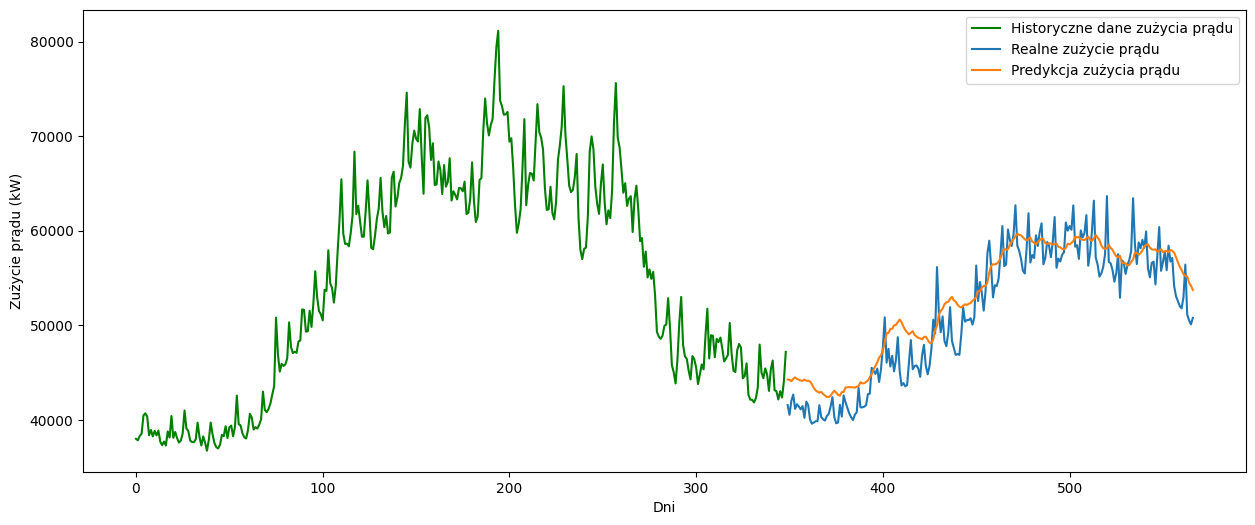

In [160]:
aa=[x for x in range(30)]
plt.figure(figsize=(15,6))
plt.plot(np.arange(0, len(Y_train[0][200:550])), Y_train[0][200:550], 'g', label="Historyczne dane zużycia prądu")
plt.plot(np.arange(len(Y_train[0][200:550]), len(Y_train[0][200:550]) + len(Y_test[0])), Y_test[0], label="Realne zużycie prądu")
plt.plot(np.arange(len(Y_train[0][200:550]), len(Y_train[0][200:550]) + len(Y_test[0])), test_predict[:,0], label="Predykcja zużycia prądu")
plt.ylabel('Zużycie prądu (kW)')
plt.xlabel('Dni')
plt.legend()
plt.show()